<a href="https://colab.research.google.com/github/zia207/r-colab/blob/main/NoteBook/Machine_Learning/Tree_based/03-01-03-06-tree-based-models-gradient-boosted-survival-model-r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1bLQ3nhDbZrCCqy_WCxxckOne2lgVvn3l)

# 3.6 Gradient Boosted Survival Model

Gradient Boosted Survival Models are a powerful class of machine learning models that extend traditional survival analysis techniques by incorporating gradient boosting methods. These models are particularly useful for predicting time-to-event outcomes while handling censored data effectively. This notebook provides an introduction to diffrent types of  Gradient Boosted Survival Models, focusing on their implementation in R.

## Overview

A **Gradient Boosted Survival Model** is a machine learning approach that combines gradient boosting with survival analysis to predict the time until an event of interest occurs, such as failure, death, or churn. Survival models deal with time-to-event data, which is often censored (i.e., the event hasn’t occurred for some subjects during the observation period). Gradient boosting enhances these models by iteratively building an ensemble of weak learners (typically decision trees) to minimize a loss function tailored to survival data.

There are several types of gradient boosted survival models, each tailored to specific survival analysis frameworks or assumptions. Thee most widely used models are **Cox Proportional Hazards-Based Gradient Boosting (CoxBoost)**,  **Gradient Boosting Survival Tree (GBST)**, and **Accelerated Failure Time (AFT) Gradient Boosting**. CoxBoost and GBST are fundamentally very similar, and in many contexts, GBST is simply a specific implementation of CoxBoost using decision trees as base learners. Coxboost can use various weak learners (trees, linear models, etc.), however, GBST is specifically designed for survival analysis and uses survival-specific splitting criteria in the trees. AFT Gradient Boosting, on the other hand, models the log-survival time directly and is based on a different assumption about how covariates affect survival time.


### Key Components

1. `Base Learners`: Typically decision trees, which are combined to form the final model.
2. `Loss Function`: A survival-specific loss, such as partial likelihood (Cox model-inspired) or a pseudo-residual-based loss.
3. `Gradient Descent`: Used to minimize the loss by adjusting the model in the direction of steepest descent.
4. `Regularization`: Techniques like shrinkage (learning rate) or tree depth constraints prevent overfitting.

### How it works

Gradient boosting iteratively adds decision trees, each correcting the errors of the previous ones, by optimizing a loss function (e.g., negative log-likelihood or a survival-specific loss). The model outputs predictions like survival probabilities, hazard functions, or cumulative risks over time, depending on the specific implementation.

In survival analysis, the model accounts for:

- `Censored data`: Observations where the event hasn’t occurred by the end of the study.
- `Time-to-event`: Predicting not just if an event occurs but when.
- `Risk or hazard`: Estimating the probability of the event at different time points.


- $ T_i $: True survival time for subject $ i $
- $ C_i $: Censoring time
- $ t_i = \min(T_i, C_i) $: Observed time
- $ \delta_i = \mathbb{I}(T_i \leq C_i) $: Event indicator (1 if event observed, 0 if censored)

We aim to model survival using a set of covariates $ \mathbf{x}_i \in \mathbb{R}^p $.


###  Cox Proportional Hazards-Based Gradient Boosting (CoxBoost)

Cox Proportional Hazards-Based Gradient Boosting is a machine learning approach that extends the Cox proportional hazards model by using gradient boosting to model the log-hazard function as a sum of decision trees. It assumes that the hazard ratios are constant over time (proportional hazards) and optimizes the negative log-partial likelihood to predict risk scores for survival data, accounting for censoring. This method excels in handling complex, non-linear relationships between covariates and survival outcomes, making it suitable for clinical applications like predicting patient survival in medical studies.

This method combines the Cox proportional hazards model with gradient boosting, where the base learners (e.g., regression trees) are used to iteratively improve the estimate of the log partial likelihood.


The hazard function for subject $ i $ is:

$$
h(t \mid \mathbf{x}_i) = h_0(t) \exp(\mathbf{x}_i^\top \boldsymbol{\beta})
$$

where:
- $ h_0(t) $: baseline hazard (non-parametric)

- $ \exp(\mathbf{x}_i^\top \boldsymbol{\beta}) $: relative risk

The partial log-likelihood (Cox, 1972) is:

$$
\ell(\boldsymbol{\beta}) = \sum_{i=1}^n \delta_i \left[ \mathbf{x}_i^\top \boldsymbol{\beta} - \log \left( \sum_{j \in \mathcal{R}(t_i)} \exp(\mathbf{x}_j^\top \boldsymbol{\beta}) \right) \right]
$$

where $ \mathcal{R}(t_i) = \{ j : t_j \geq t_i \} $ is the risk set at time $ t_i $.

Gradient Boosting Framework

Let $ f_m(\mathbf{x}) $ be the additive model at iteration $ m $:

$$
f_m(\mathbf{x}) = f_{m-1}(\mathbf{x}) + \nu \cdot \gamma_m h_m(\mathbf{x})
$$

where:
- $ h_m(\mathbf{x}) $: weak learner (e.g., regression tree)

- $ \gamma_m $: coefficient

- $ \nu $: learning rate

In **CoxBoost**, the loss function is the negative log partial likelihood:

$$
L(y, f) = -\ell(f) = -\sum_{i=1}^n \delta_i \left[ f(\mathbf{x}_i) - \log \left( \sum_{j \in \mathcal{R}(t_i)} \exp(f(\mathbf{x}_j)) \right) \right]
$$

Gradients (pseudo-residuals) at step $ m $ are computed as:

$$
r_{im} = -\left[ \frac{\partial L}{\partial f(\mathbf{x}_i)} \right]_{f = f_{m-1}} = \delta_i - \sum_{j \in \mathcal{R}(t_i)} \frac{ \exp(f_{m-1}(\mathbf{x}_j)) }{ \sum_{k \in \mathcal{R}(t_i)} \exp(f_{m-1}(\mathbf{x}_k)) }
$$

This is the difference between the observed event indicator and the model-based risk weight (similar to a "score" residual).

Then:

- Fit a regression tree $ h_m(\mathbf{x}) $ to the pseudo-residuals $ r_{im} $

- Compute optimal $ \gamma_m $ by line search in the original Cox likelihood

- Update: $ f_m(\mathbf{x}) = f_{m-1}(\mathbf{x}) + \nu \gamma_m h_m(\mathbf{x}) $

> **Note**: The baseline hazard $ h_0(t) $ remains unspecified; boosting estimates the log-risk $ f(\mathbf{x}) = \log h(t|\mathbf{x}) - \log h_0(t) $


### Gradient Boosting Survival Trees (GBST)

Gradient Boosting Survival Tree (GBST) is a specialized gradient boosting approach for survival analysis that uses survival trees as base learners, designed to handle time-to-event data with censoring. These trees split nodes based on survival-specific criteria, such as log-rank tests, to maximize differences in survival outcomes. GBST iteratively combines these trees to optimize a survival-related loss function, producing survival probabilities or hazard functions. Its strength lies in its interpretability and ability to model complex survival patterns without strict assumptions like proportional hazards, making it ideal for medical research applications like predicting patient survival times.

GBST is a **generic framework** for gradient boosting in survival analysis. It can be instantiated with different loss functions. The **CoxBoost** above is a special case of GBST.


Use a survival-specific loss $ \rho(t_i, \delta_i, f(\mathbf{x}_i)) $, e.g., Cox loss or others.

General boosting steps:

1. Initialize $ f_0(\mathbf{x}) = \arg\min_{c} \sum_{i=1}^n \rho(t_i, \delta_i, c) $

2. For $ m = 1 $ to $ M $:
   - Compute pseudo-residuals:
   
$$ r_{im} = -\left[ \frac{\partial \rho(t_i, \delta_i, f_{m-1}(\mathbf{x}_i))}{\partial f_{m-1}(\mathbf{x}_i)} \right]   $$
   - Fit a regression tree $ h_m(\mathbf{x}) $ to $ r_{im} $
   
   - Compute $ \gamma_m = \arg\min_\gamma \sum_{i=1}^n \rho(t_i, \delta_i, f_{m-1}(\mathbf{x}_i) + \gamma h_m(\mathbf{x}_i)) $
   
   - Update: $ f_m(\mathbf{x}) = f_{m-1}(\mathbf{x}) + \nu \gamma_m h_m(\mathbf{x}) $

So **CoxBoost is a GBST with Cox partial likelihood loss**.

Other losses in GBST may include:

- Weighted log-likelihood
- Rank-based losses (e.g., concordance)
- Brier score for survival (integrated)

### Accelerated Failure Time (AFT) Gradient Boosting (AFTBoost)

Accelerated Failure Time (AFT) Gradient Boosting is a machine learning method for survival analysis that models the log-survival time as a function of covariates, assuming that predictors accelerate or decelerate the time to an event. It uses gradient boosting to combine decision trees, optimizing a likelihood-based loss function (e.g., Weibull or log-normal) that accounts for censored data. Unlike hazard-based models, AFT directly predicts survival times, making it intuitive for applications like predicting time to machine failure or patient recovery.

The AFT model assumes:

$$
\log T_i = \mathbf{x}_i^\top \boldsymbol{\beta} + \sigma \epsilon_i
$$

where $ \epsilon_i $ is an error term (e.g., normal, extreme value, logistic), and $ \sigma $ is a scale parameter.

This implies that covariates **accelerate or decelerate time**:

$$
T_i = \exp(\mathbf{x}_i^\top \boldsymbol{\beta}) \cdot V_i
$$

where $ V_i = \exp(\sigma \epsilon_i) $ is the baseline survival time.

`Likelihood with Censoring`:

Let $ y_i = \log t_i $. The observed log-time and event indicator define the likelihood contribution:

$$
\mathcal{L}_i = \left[ \frac{1}{\sigma} f_\epsilon\left( \frac{y_i - \mathbf{x}_i^\top \boldsymbol{\beta}}{\sigma} \right) \right]^{\delta_i} \cdot \left[ 1 - F_\epsilon\left( \frac{y_i - \mathbf{x}_i^\top \boldsymbol{\beta}}{\sigma} \right) \right]^{1 - \delta_i}
$$

where $ f_\epsilon $ and $ F_\epsilon $ are the PDF and CDF of the error distribution.

Common choices:
- Normal: $ \epsilon \sim \mathcal{N}(0,1) $ → log-normal AFT

- Extreme value: $ \epsilon \sim \text{Gumbel} $ → Weibull AFT

`Gradient Boosting for AFT`:

Let $ f(\mathbf{x}) $ model $ \mathbf{x}^\top \boldsymbol{\beta} $, and optionally $ s(\mathbf{x}) $ model $ \log \sigma $.

**Case 1: Fixed $ \sigma $**

Use log-likelihood as loss:

$$
L(f) = -\sum_{i=1}^n \left[ \delta_i \log f_\epsilon\left( \frac{y_i - f(\mathbf{x}_i)}{\sigma} \right) + (1 - \delta_i) \log \left(1 - F_\epsilon\left( \frac{y_i - f(\mathbf{x}_i)}{\sigma} \right)\right) \right]
$$

Pseudo-residuals:

$$
r_{im} = -\left[ \frac{\partial L}{\partial f(\mathbf{x}_i)} \right]_{f = f_{m-1}} = \delta_i \cdot \frac{ f_\epsilon'\left( z_i^{(m-1)} \right) }{ f_\epsilon\left( z_i^{(m-1)} \right) } + (1 - \delta_i) \cdot \frac{ f_\epsilon\left( z_i^{(m-1)} \right) }{ 1 - F_\epsilon\left( z_i^{(m-1)} \right) }
$$

where $ z_i^{(m-1)} = \frac{y_i - f_{m-1}(\mathbf{x}_i)}{\sigma} $

Then:
- Fit tree $ h_m(\mathbf{x}) $ to $ r_{im} $

- Update $ f_m(\mathbf{x}) = f_{m-1}(\mathbf{x}) + \nu \gamma_m h_m(\mathbf{x}) $

**Case 2: Learn $ \sigma $ jointly**

Use two models:

- $ f(\mathbf{x}) $: location (mean)

- $ s(\mathbf{x}) $: log-scale

### Comparison: Similarities and Differences

| Feature | **CoxBoost** | **GBST** | **AFTBoost** |
|--------|------------|----------|------------|
| **Model Type** | Semi-parametric (PH) | Framework (can be PH or other) | Parametric (AFT) |
| **Assumption** | Proportional hazards | Depends on loss | Accelerated time |
| **Loss Function** | Negative partial Cox log-likelihood | Any survival loss (Cox, rank, etc.) | Full log-likelihood (with censoring) |
| **Output** | Log-hazard ratio $ f(\mathbf{x}) $ | Flexible (depends on loss) | $ \log T_i $ prediction |
| **Baseline** | $ h_0(t) $ unspecified | Depends on loss | Parametric baseline distribution |
| **Gradient Form** | $ r_{im} = \delta_i - \sum_{j \in \mathcal{R}(t_i)} w_j $ | $ r_{im} = -\partial \rho / \partial f $ | $ r_{im} = \text{likelihood score} $ |
| **Interpretability** | Hazard ratios | Depends on loss | Time acceleration factor $ \exp(\beta_j) $ |
| **Tree Fitting** | On pseudo-residuals | On pseudo-residuals | On pseudo-residuals |
| **Prediction** | Risk score, survival curves (via Breslow) | Depends on loss | Predict $ \log T_i $, simulate survival |


## Setup R in Python Runtype

### Install {rpy2}

{rpy2} is a Python package that provides an interface to the R programming language, allowing Python users to run R code, call R functions, and manipulate R objects directly from Python. It enables seamless integration between Python and R, leveraging R's statistical and graphical capabilities while using Python's flexibility. The package supports passing data between the two languages and is widely used for statistical analysis, data visualization, and machine learning tasks that benefit from R's specialized librari

In [1]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.5.17
Uninstalling rpy2-3.5.17:
  Successfully uninstalled rpy2-3.5.17
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 701.2 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp311-cp311-linux_x86_64.whl size=314979 sha256=06460935773805ea7ab72c0df74b8127ebcacac9b3d926dc9f81726f78c80ac3
  Stored in directory: /root/.cache/pip/wheels/e9/55/d1/47be85a5f3f1e1f4d1e91cb5e3a4dcb40dd72147f184c5a5ef
Successfully built rpy2


### Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Gradient Boosted Survival Models with R

This section provides a comprehensive guide to implementing the CoxBoost, GBST and AFTBoost using R, specifically utilizing the {CoxBoost}, {gbm} and {xgboost} packages. The steps include loading necessary libraries, preparing the dataset, fitting the model, validating it, and visualizing results.

### Load and Check Required Libraries

In [ ]:
%%R
# install Coxboost
if (!require("devtools", quietly = TRUE))
    install.packages("devtools",ib='drive/My Drive/R/')
devtools::install_github("binderh/CoxBoost",lib='drive/My Drive/R/')

In [ ]:
%%R
# Install pacman
if (!requireNamespace("pacman", quietly = TRUE)) {
  install.packages("pacman", lib='drive/My Drive/R/')
}

In [5]:
%%R
packages <- c('tidyverse',
              'plyr',
              'survival',
              'risksetROC',
              'survivalROC',
              'riskRegression',
              'pracma',
              'survminer',
              'survcomp',
              'CoxBoost',
              'gbm',
              'xgboost',
              'pec'

         )

### Install Missing Packages

In [ ]:
%%R
# Install missing packages
new.packages <- packages[!(packages %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')

### Verify Installation

In [7]:
%%R
# set library path
.libPaths('drive/My Drive/R')
# Verify installation
cat("Installed packages:\n")
print(sapply(packages, requireNamespace, quietly = TRUE))

Installed packages:
     tidyverse           plyr       survival     risksetROC    survivalROC 
          TRUE           TRUE           TRUE           TRUE           TRUE 
riskRegression         pracma      survminer       survcomp       CoxBoost 
          TRUE           TRUE           TRUE           TRUE           TRUE 
           gbm        xgboost            pec 
          TRUE           TRUE           TRUE 


### Load R Packages

In [ ]:
%%R
# set library path
.libPaths('drive/My Drive/R')
# Load packages with suppressed messages
invisible(lapply(packages, function(pkg) {
  suppressPackageStartupMessages(library(pkg, character.only = TRUE))
}))

Or you can use `{pacman}` package to load all packages at once, which is a convenient way to manage package dependencies in R. The `p_load` function loads the specified packages, installing them if they are not already installed, and suppresses messages during loading.

In [6]:
%%R
# set library path
.libPaths('drive/My Drive/R')
# Load packages with suppressed messages
pacman::p_load('tidyverse',
              'plyr',
              'survival',
              'risksetROC',
              'survivalROC',
              'riskRegression',
              'pracma',
              'survminer',
              'survcomp',
              'CoxBoost',
              'gbm',
              'xgboost',
              'pec'
         )

### Check Loaded Packages

In [8]:
%%R
# Check loaded packages
cat("Successfully loaded packages:\n")
print(search()[grepl("package:", search())])# Check loaded packageswer)

Successfully loaded packages:
 [1] "package:pec"            "package:xgboost"        "package:gbm"           
 [4] "package:CoxBoost"       "package:Matrix"         "package:survcomp"      
 [7] "package:prodlim"        "package:survminer"      "package:ggpubr"        
[10] "package:pracma"         "package:riskRegression" "package:survivalROC"   
[13] "package:risksetROC"     "package:MASS"           "package:survival"      
[16] "package:plyr"           "package:lubridate"      "package:forcats"       
[19] "package:stringr"        "package:dplyr"          "package:purrr"         
[22] "package:readr"          "package:tidyr"          "package:tibble"        
[25] "package:ggplot2"        "package:tidyverse"      "package:tools"         
[28] "package:stats"          "package:graphics"       "package:grDevices"     
[31] "package:utils"          "package:datasets"       "package:methods"       
[34] "package:base"          



## Cox Proportional Hazards-Based Gradient Boosting (CoxBoost)

The Cox Proportional Hazards-Based Gradient Boosting Model combines the Cox proportional hazards framework with gradient boosting to model survival data, capturing non-linear relationships and interactions while handling censored observations. In R, packages like {CoxBoost}, {xgboost}, and {gbm} enable this approach. Below is a step-by-step implementation of CoxBoost model, including data preparation, model fitting, validation, and visualization.  It is a semi-parametric regression model widely used for such tasks. The classical Cox model assumes:

- Linear effects of covariates

- Proportional hazards

- No interactions unless explicitly added

To overcome these limitations, **gradient boosting** can be adapted to optimize the **partial likelihood** of the Cox model. This results in a **boosted Cox model** that learns complex, non-linear patterns in the data by sequentially fitting weak learners (typically decision trees) to improve survival risk predictions. This approach is implemented in libraries like `CoxBoost`,  `gbm` and `xgboost` using a custom objective function based on the **Cox partial log-likelihood**.

### Data and Data Preparation

First, ensure you have the required packages installed and load the `lung` dataset from the `survival` package. The `lung` dataset contains survival data for 228 patients with advanced lung cancer, including variables like `time` (survival time in days), `status` (censoring indicator: 1 = censored, 2 = dead), and covariates like `age`, `sex`, `ph.ecog`, etc.


In [9]:
%%R
# Set seed for reproducibility
set.seed(123)

# Prepare lung dataset
suppressWarnings(data(lung))
# Remove missing values
lung_complete <- lung %>% na.omit()

# Split into 70% training and 30% testing
n <- nrow(lung_complete)
train_idx <- sample(1:n, size = round(0.7 * n))
train_data <- lung_complete[train_idx, ]
test_data <- lung_complete[-train_idx, ]

# Training data
time_train <- train_data$time
status_train <- train_data$status
X_train <- train_data[, !(names(train_data) %in% c("time", "status"))]
X_train_matrix <- as.matrix(X_train)

# Test data
time_test <- test_data$time
status_test <- test_data$status
X_test <- test_data[, !(names(test_data) %in% c("time", "status"))]
X_test_matrix <- as.matrix(X_test)



### Fit Initial CoxBoost Model


First, we fit an initial CoxBoost model using the training data. This model will be used to estimate the baseline cumulative hazard and compute survival curves.  `CoxBoost()` function is used to fit the model, specifying the time, status, and predictor matrix. The `stepno` parameter controls the number of boosting iterations, and `penalty` is set to 100 for regularization. The `criterion` is set to "pscore" for partial score optimization, and `standardize` is set to TRUE to standardize the predictors.

In [10]:
%%R
# Fit initial CoxBoost model
initial_model <- CoxBoost(
  time = time_train,
  status = status_train,
  x = X_train_matrix,
  stepno = 100,
  penalty = 100,
  criterion = "pscore",
  standardize = TRUE
)

summary(initial_model)

100 boosting steps resulting in 8 non-zero coefficients  
partial log-likelihood: -157.7046 

parameter estimates > 0:
 inst, sex, pat.karno, meal.cal, wt.loss 
parameter estimates < 0:
 age, ph.ecog, ph.karno 


In [ ]:
%%R
# variables contained in the fitted object
names(initial_model)

 [1] "time"             "status"           "event.times"      "weights"         
 [5] "strata"           "stratum"          "stepno"           "xnames"          
 [9] "n"                "p"                "meanx"            "sdx"             
[13] "standardize"      "causes"           "coefficients"     "linear.predictor"
[17] "Lambda"           "scoremat"         "logplik"         


In [ ]:
%%R
# coefficient estimates
dim(initial_model$coefficients)

[1] 101   8


In [ ]:
%%R
# linear predictor estimates
dim(initial_model$linear.predictor)

[1] 101 117


In [ ]:
%%R
# cumulative baseline hazard estimates
dim(initial_model$Lambda)

[1] 101  34


### Prediction and Validation

In [ ]:
%%R
# Initial model validation on test data
# Get risk scores
initial_pred <- predict(initial_model, newdata = X_test_matrix, type = "risk")

# Debug: Check dimensions and content of initial_pred
cat("Dimensions of initial_pred =", dim(initial_pred), "\n")
cat("Length of initial_pred (as vector) =", length(as.vector(initial_pred)), "\n")
cat("First few values of initial_pred:", head(as.vector(initial_pred)), "\n")

Dimensions of initial_pred = 50 106 
Length of initial_pred (as vector) = 5300 
First few values of initial_pred: 0.970567 0.9873503 0.9884359 0.958653 0.9772657 0.9531882 


In [ ]:
%%R
# Handle case where initial_pred is a matrix
if (is.matrix(initial_pred)) {
  cat("initial_pred is a matrix, selecting final column\n")
  initial_pred_vec <- as.vector(initial_pred[, ncol(initial_pred)])
} else {
  initial_pred_vec <- as.vector(initial_pred)
}

initial_pred is a matrix, selecting final column


### C-Index of Initial Model

C-index is a measure of the model's discriminatory ability, indicating how well the model can distinguish between individuals who experience the event and those who do not. A C-index of 0.5 indicates no discrimination (random prediction), while a C-index of 1.0 indicates perfect discrimination.

In [ ]:
%%R
# Custom C-index function as a fallback
custom_cindex <- function(pred, time, status) {
  concordant <- 0
  total_pairs <- 0
  n <- length(time)
  for (i in 1:(n-1)) {
    for (j in (i+1):n) {
      if (status[i] == 1 && status[j] == 1) {
        if (time[i] < time[j] && pred[i] > pred[j]) concordant <- concordant + 1
        if (time[j] < time[i] && pred[j] > pred[i]) concordant <- concordant + 1
        total_pairs <- total_pairs + 1
      } else if (status[i] == 1 && status[j] == 0) {
        if (time[i] < time[j] && pred[i] > pred[j]) concordant <- concordant + 1
        total_pairs <- total_pairs + 1
      } else if (status[j] == 1 && status[i] == 0) {
        if (time[j] < time[i] && pred[j] > pred[i]) concordant <- concordant + 1
        total_pairs <- total_pairs + 1
      }
    }
  }
  if (total_pairs == 0) return(NA)
  return(concordant / total_pairs)
}

In [ ]:
%%R
# Try C-index with survcomp on test data
initial_cindex <- NA
tryCatch({
  initial_cindex <- concordance.index(
    x = initial_pred_vec,
    surv.time = time_test,
    surv.event = status_test,
    method = "noether"
  )$c.index
  cat("survcomp::concordance.index succeeded for initial model\n")
}, error = function(e) {
  cat("survcomp::concordance.index failed for initial model:", e$message, "\n")
  # Fallback 1: Try survivalROC
  tryCatch({
    roc <- survivalROC(
      Stime = time_test,
      status = status_test,
      marker = initial_pred_vec,
      predict.time = median(time_test),
      method = "NNE"
    )
    initial_cindex <<- roc$AUC
    cat("Fallback C-index (AUC at median time) for initial model:", initial_cindex, "\n")
  }, error = function(e2) {
    cat("survivalROC failed for initial model:", e2$message, "\n")
    # Fallback 2: Custom C-index
    initial_cindex <<- custom_cindex(initial_pred_vec, time_test, status_test)
    cat("Custom C-index for initial model:", initial_cindex, "\n")
  })
})

print(paste("Initial model C-index:", round(initial_cindex, 3)))

survcomp::concordance.index succeeded for initial model
[1] "Initial model C-index: 0.301"


### Integrated Brier Score (IBS)

The Integrated Brier Score (IBS) is a metric used to evaluate the predictive performance of survival models, such as the CoxBoost model in your script. It measures the mean squared error of predicted survival probabilities over a specified time range, accounting for censoring

In [ ]:
%%R
eval_times <- seq(0, max(time_test), length.out = 100)
initial_cif <- predict(initial_model, newdata = X_test_matrix, type = "CIF", times = eval_times)
initial_brier <- rep(NA, length(eval_times))
for (i in 1:length(eval_times)) {
  km_fit <- survfit(Surv(time_test, 1 - status_test) ~ 1, data = test_data)
  G_t <- summary(km_fit, times = eval_times[i])$surv
  if (length(G_t) == 0) G_t <- 1
  initial_brier[i] <- mean((as.numeric(time_test > eval_times[i]) - (1 - initial_cif[, i]))^2 / G_t, na.rm = TRUE)
}
initial_ibs <- mean(initial_brier, na.rm = TRUE)
print(paste("Initial model IBS:", round(initial_ibs, 3)))

[1] "Initial model IBS: 0.396"


### Kaplan-Meier baseline IBS

The Kaplan-Meier baseline Integrated Brier Score (IBS) is calculated using the Kaplan-Meier survival estimates as a baseline for comparison. This provides a reference point to evaluate the performance of the CoxBoost model against a non-parametric survival estimate.

In [ ]:
%%R
# Kaplan-Meier baseline IBS
km_fit <- survfit(Surv(time_test, status_test) ~ 1, data = test_data)
km_surv <- summary(km_fit, times = eval_times)$surv
km_brier <- rep(NA, length(eval_times))
for (i in 1:length(eval_times)) {
  G_t <- summary(survfit(Surv(time_test, 1 - status_test) ~ 1), times = eval_times[i])$surv
  if (length(G_t) == 0) G_t <- 1
  km_brier[i] <- mean((as.numeric(time_test > eval_times[i]) - km_surv[i])^2 / G_t, na.rm = TRUE)
}
km_ibs <- mean(km_brier, na.rm = TRUE)
print(paste("Kaplan-Meier baseline IBS:", round(km_ibs, 3)))

[1] "Kaplan-Meier baseline IBS: 0.113"


### Crosss-Validation for Penalty Parameter

Cross-validation is used to select the optimal penalty parameter for the CoxBoost model. The `optimCoxBoostPenalty()` function performs cross-validation, returning the mean log partial likelihood for different penalty values. The optimal penalty is chosen based on the minimum mean log partial likelihood.

In [ ]:
%%R
cv_penalty <-optimCoxBoostPenalty(time = time_train,
                                  status = status_train,
                                  x = X_train_matrix,
                                  trace=TRUE,
                                  start.penalty=500)

### Cross-Validation for Boosting Steps

Cross-validation is also performed to determine the optimal number of boosting steps. The `cv.CoxBoost()` function is used to perform cross-validation, returning the mean log partial likelihood for different step numbers. The optimal number of steps is chosen based on the minimum mean log partial likelihood.

In [ ]:
%%R
# Cross-validation for boosting steps
cv_steps <- tryCatch({
  cv.CoxBoost(
    time = time_train,
    status = status_train,
    x = X_train_matrix,
    maxstepno = 100,
    penalty = 100,
    K = 10,
    type = "verweij"
  )
}, error = function(e) {
  cat("cv.CoxBoost for steps failed:", e$message, "\n")
  cat("Using default stepno = 100\n")
  return(NULL)
})
if (!is.null(cv_steps) && !any(is.na(cv_steps$mean.logplik))) {
  optimal_steps <- which.min(cv_steps$mean.logplik)
} else {
  optimal_steps <- 100
}
cat("Optimal Steps:", optimal_steps, "\n")

Optimal Steps: 101 


### Fit Final Model

Now that we have the optimal penalty and number of steps, we can fit the final CoxBoost model using these parameters. The `CoxBoost()` function is used again, this time with the optimal parameters obtained from cross-validation. The model is fitted on the training data, and a summary of the model is print

In [ ]:
%%R
# Fit final model
final_model <- tryCatch({
  CoxBoost(
    time = time_train,
    status = status_train,
    x = X_train_matrix,
    stepno = optimal_steps,
    penalty = optimal_penalty,
    standardize = FALSE
  )
}, error = function(e) {
  cat("CoxBoost final model failed:", e$message, "\n")
  cat("Using default parameters: stepno = 100, penalty = 100\n")
  CoxBoost(
    time = time_train,
    status = status_train,
    x = X_train_matrix,
    stepno = 100,
    penalty = 100,
    standardize = FALSE
  )
})
summary(final_model)

CoxBoost final model failed: object 'optimal_penalty' not found 
Using default parameters: stepno = 100, penalty = 100
100 boosting steps resulting in 8 non-zero coefficients  
partial log-likelihood: -157.7735 

parameter estimates > 0:
 inst, sex, ph.karno, pat.karno, meal.cal, wt.loss 
parameter estimates < 0:
 age, ph.ecog 


### Final model validation on test data

In [ ]:
%%R
# prediction
final_pred <- predict(final_model, newdata = X_test_matrix, type = "risk")
if (is.matrix(final_pred)) {
  final_pred_vec <- as.vector(final_pred[, ncol(final_pred)])
} else {
  final_pred_vec <- as.vector(final_pred)
}

In [ ]:
%%R
# Try C-index for final model
final_cindex <- NA
tryCatch({
  final_cindex <- concordance.index(
    x = final_pred_vec,
    surv.time = time_test,
    surv.event = status_test,
    method = "noether"
  )$c.index
  cat("survcomp::concordance.index succeeded for final model\n")
}, error = function(e) {
  cat("survcomp::concordance.index failed for final model:", e$message, "\n")
  tryCatch({
    roc <- survivalROC(
      Stime = time_test,
      status = status_test,
      marker = final_pred_vec,
      predict.time = median(time_test),
      method = "NNE"
    )
    final_cindex <<- roc$AUC
    cat("Fallback C-index (AUC at median time) for final model:", final_cindex, "\n")
  }, error = function(e2) {
    cat("survivalROC failed for final model:", e2$message, "\n")
    final_cindex <<- custom_cindex(final_pred_vec, time_test, status_test)
    cat("Custom C-index for final model:", final_cindex, "\n")
  })
})
print(paste("Final model C-index:", round(final_cindex, 3)))

survcomp::concordance.index succeeded for final model
[1] "Final model C-index: 0.31"


In [ ]:
%%R
# Manual IBS for final model
final_cif <- predict(final_model, newdata = X_test_matrix, type = "CIF", times = eval_times)
final_brier <- rep(NA, length(eval_times))
for (i in 1:length(eval_times)) {
  km_fit <- survfit(Surv(time_test, 1 - status_test) ~ 1, data = test_data)
  G_t <- summary(km_fit, times = eval_times[i])$surv
  if (length(G_t) == 0) G_t <- 1
  final_brier[i] <- mean((as.numeric(time_test > eval_times[i]) - (1 - final_cif[, i]))^2 / G_t, na.rm = TRUE)
}
final_ibs <- mean(final_brier, na.rm = TRUE)
print(paste("Final model IBS:", round(final_ibs, 3)))

[1] "Final model IBS: 0.395"


### Survival Curves

Finally, we can visualize the survival curves based on the predicted risk scores from the final CoxBoost model. The survival probabilities are computed from the cumulative incidence function (CIF) estimates, and a plot is generated to show the average survival curve across all test samples.

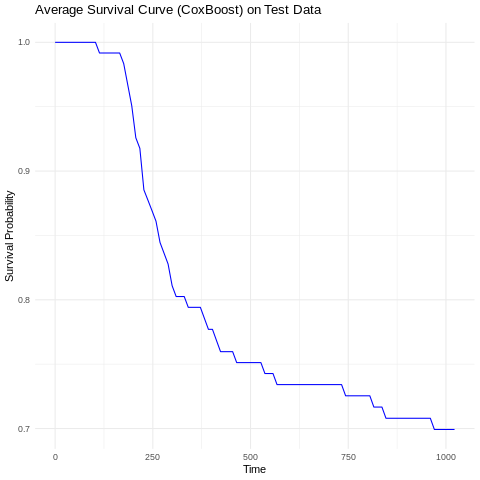

In [ ]:
%%R

surv_prob_final <- 1 - final_cif
surv_data <- data.frame(
  time = eval_times,
  surv = colMeans(surv_prob_final)
)
ggplot(surv_data, aes(x = time, y = surv)) +
  geom_line(color = "blue") +
  labs(title = "Average Survival Curve (CoxBoost) on Test Data", x = "Time", y = "Survival Probability") +
  theme_minimal()


### Variable Importance

Variable importance can be assessed by examining the absolute values of the coefficients from the final CoxBoost model. This provides insights into which predictors have the most significant impact on survival risk.

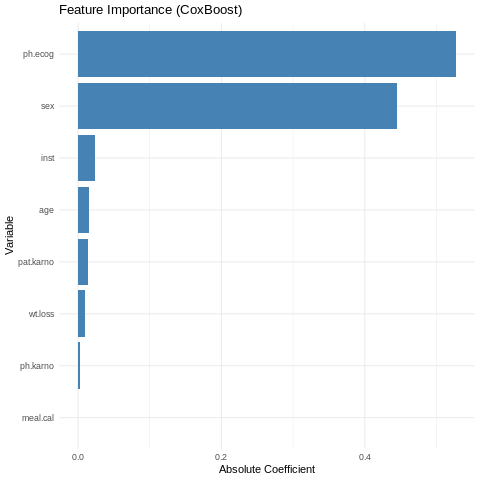

In [ ]:
%%R
importance <- coef(final_model)
imp_data <- data.frame(
  Variable = colnames(X_train_matrix),
  Importance = abs(importance)
) %>% filter(Importance != 0)

ggplot(imp_data, aes(x = reorder(Variable, Importance), y = Importance)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  coord_flip() +
  labs(title = "Feature Importance (CoxBoost)", x = "Variable", y = "Absolute Coefficient") +
  theme_minimal()


## Gradient Boosting Survival Tree (GBST)

GBST applies gradient boosting directly to survival data using tree-based models, but it typically uses `rank-based` or `log-likelihood` loss functions tailored to survival, such as the log partial likelihood (Cox-type) or concordance-based loss. It extends the gradient boosting framework—popularized by algorithms like Gradient Boosting Machines (GBM) and XGBoost—to handle survival outcomes by optimizing survival-specific loss functions. Unlike traditional survival models such as the **Cox proportional hazards model**, GBST does not assume proportional hazards. GBST can capture complex, non-linear relationships and interactions in the data. GBST may use different loss functions (e.g., ranking), while CoxBoost specifically targets the Cox partial likelihood.

### GBST with gbm

GBST operates similarly to CoxBoost by integrating the Cox proportional hazards model with gradient boosting techniques for analyzing survival data. This approach allows for flexible modeling of survival times while accounting for censoring, making it suitable for complex survival datasets. The {gbm} package in R provides an implementation of this method, enabling users to fit models that optimize the Cox partial likelihood using gradient boosting.  Below is a step-by-step guide to fitting a GBST model using the {gbm} package, including data preparation, model fitting, validation, and visualization.

#### Load and Prepare Data

In [11]:
%%R
set.seed(123)

# Prepare lung dataset
data(lung)
# Remove missing values
lung_complete <- lung %>% na.omit()

# Split into 70% training and 30% testing
n <- nrow(lung_complete)
train_idx <- sample(1:n, size = round(0.7 * n))
train_data <- lung_complete[train_idx, ]
test_data <- lung_complete[-train_idx, ]

#### Fit GBST Model

GBST is implemented using the `{gbm}` package, which allows for fitting gradient boosting models with various loss functions. For survival analysis, we can use the `distribution = "coxph"` option to specify that we want to fit a Cox proportional hazards model using gradient boosting.

In [12]:
%%R
# Fit Gradient Boosting Survival Tree model
set.seed(123)
gbst_model <- gbm(
  formula = Surv(time, status) ~ age + sex + ph.ecog + ph.karno + pat.karno + meal.cal + wt.loss,
  data = train_data,
  distribution = "coxph",          # Cox model
  n.trees = 1000,                  # Number of boosting iterations
  interaction.depth = 3,           # Tree depth
  shrinkage = 0.01,                # Learning rate
  bag.fraction = 0.5,              # Subsampling
  # cv.folds = 5,                  # 5-fold CV for optimal n.trees
  n.minobsinnode = 10
)

In [13]:
%%R
print(gbst_model)

gbm(formula = Surv(time, status) ~ age + sex + ph.ecog + ph.karno + 
    pat.karno + meal.cal + wt.loss, distribution = "coxph", data = train_data, 
    n.trees = 1000, interaction.depth = 3, n.minobsinnode = 10, 
    shrinkage = 0.01, bag.fraction = 0.5)
A gradient boosted model with coxph loss function.
1000 iterations were performed.
There were 7 predictors of which 7 had non-zero influence.


#### Cross-valiadtion

To determine the optimal number of trees, we can use cross-validation. The `{gbm}` package provides a built-in method to perform cross-validation and select the best number of trees based on the minimum cross-validated error.

Optimal number of trees: 33 


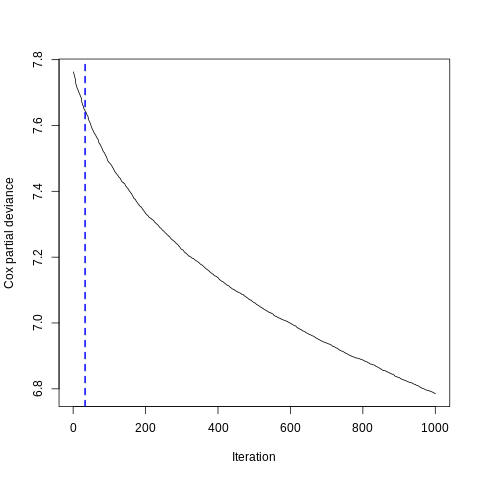

In [14]:
%%R
# Cross-validation to find optimal number of trees
best_iter <- gbm.perf(gbst_model)
cat("Optimal number of trees:", best_iter, "\n")

#### Vraiable Importnace

summary of the model provides information about the fitted model, including variable importance and the number of trees used.

                var   rel.inf
age             age 26.897583
wt.loss     wt.loss 24.790676
meal.cal   meal.cal 19.234726
pat.karno pat.karno 10.250152
ph.karno   ph.karno  7.149922
ph.ecog     ph.ecog  5.970591
sex             sex  5.706349


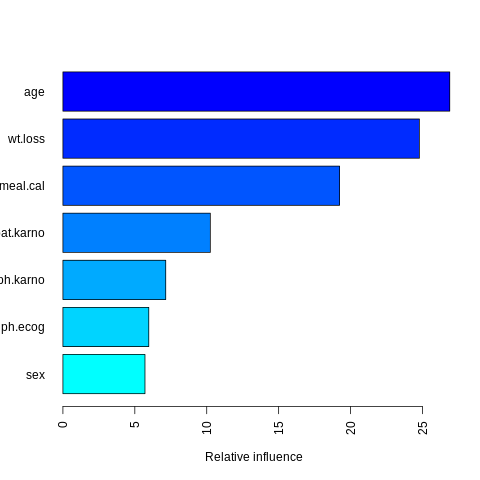

In [15]:
%%R
# Variable importance
summary(gbst_model, las = 2)  # las = 2 rotates axis labels

#### Predictioon and Validation

In [ ]:
%%R
# Predict risk scores for test data
risk_scores <- predict(gbst_model, newdata = test_data, n.trees = best_iter, type = "response")
print(paste("Cox GBM Risk Scores:", round(risk_scores, 3)))

#### Concordance index (C-index)

In [18]:
%%R
# Compute concordance index (C-index)
cat("C-index:", concordance(Surv(time, status) ~risk_scores , data = test_data)$concordance, "\n")

C-index: 0.3936382 


#### Integrated Brier Score (IBS)

In [ ]:
%%R
# Calculate Integrated Brier Score (IBS)
# Define evaluation times
eval_times <- seq(0, max(test_data$time), length.out = 100)
# Initialize Brier score vector
brier_scores <- numeric(length(eval_times))
# Loop through evaluation times
for (i in seq_along(eval_times)) {
  # Get survival probabilities at evaluation time
  surv_probs <- predict(gbst_model, newdata = test_data, n.trees = best_iter, type = "response")
  # Calculate Brier score
  brier_scores[i] <- mean((as.numeric(test_data$time > eval_times[i]) - surv_probs)^2)
}
# Calculate Integrated Brier Score (IBS)
ibs <- mean(brier_scores, na.rm = TRUE)
cat("Integrated Brier Score (IBS):", round(ibs, 3), "\n")

Integrated Brier Score (IBS): 0.332 


#### Survival Curves

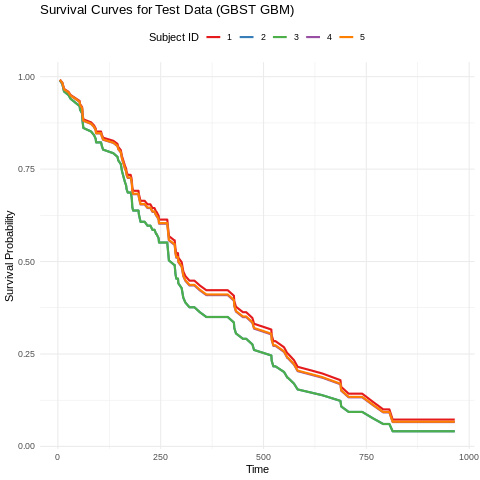

In [ ]:
%%R
# Estimate baseline survival function using training data
# Fit a Cox model to get baseline hazard (approximation for GBST)
cox_model <- coxph(Surv(time, status) ~ 1, data = train_data)
base_haz <- basehaz(cox_model, centered = FALSE)

# Compute survival probabilities for test data
surv_probs <- matrix(NA, nrow = nrow(test_data), ncol = length(base_haz$time))
for (i in 1:nrow(test_data)) {
  surv_probs[i, ] <- exp(-base_haz$hazard * exp(risk_scores[i]))
}

# Create a data frame for plotting
surv_df <- data.frame(
  Time = rep(base_haz$time, nrow(test_data)),
  Survival = as.vector(t(surv_probs)),
  Subject = rep(1:nrow(test_data), each = length(base_haz$time))
)

# Plot survival curves for a subset of subjects (e.g., first 5 for clarity)
subset_subjects <- 1:min(5, nrow(test_data))
surv_df_subset <- surv_df[surv_df$Subject %in% subset_subjects, ]

ggplot(surv_df_subset, aes(x = Time, y = Survival, color = factor(Subject))) +
  geom_line(linewidth = 1) +
  labs(title = "Survival Curves for Test Data (GBST GBM)",
       x = "Time", y = "Survival Probability",
       color = "Subject ID") +
  theme_minimal() +
  scale_color_brewer(palette = "Set1") +
  theme(legend.position = "top")

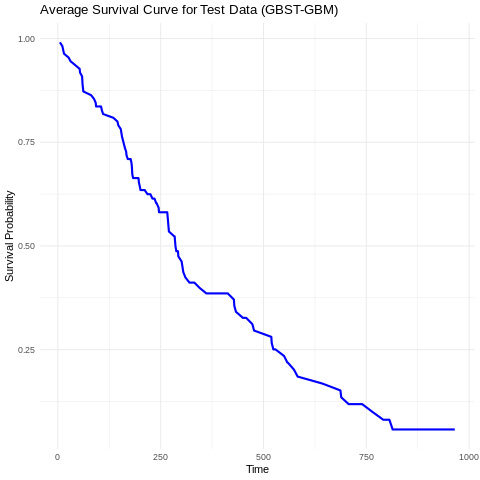

In [ ]:
%%R
# Optional: Plot average survival curve across all test subjects
avg_surv <- colMeans(surv_probs)
avg_surv_df <- data.frame(Time = base_haz$time, Survival = avg_surv)

ggplot(avg_surv_df, aes(x = Time, y = Survival)) +
  geom_line(linewidth = 1, color = "blue") +
  labs(title = "Average Survival Curve for Test Data (GBST-GBM)",
       x = "Time", y = "Survival Probability") +
  theme_minimal()

### GBST with xgboost

The Gradient Boosting Survival Tree (GBST) model can also be implemented using the {xgboost} package in R. This approach allows for efficient handling of large datasets and provides flexibility in defining custom loss functions for survival analysis. Below is a step-by-step guide to fitting a GBST model using {xgboost}, including data preparation, model fitting, validation, and visualization.

#### Load and Prepare Data

In [19]:
%%R
# Set seed for reproducibility
set.seed(123)

# Load lung dataset
data(lung, package = "survival")

# Prepare data: remove missing values and select relevant features
lung_clean <- lung %>%
  na.omit() %>%
  dplyr::select(time, status, age, sex, ph.ecog, ph.karno, pat.karno, meal.cal, wt.loss)

# Convert status to 0/1 (xgboost expects 0 = censored, 1 = event)
lung_clean$status <- lung_clean$status - 1

# Split data into 70% training and 30% testing
trainIndex <- caret::createDataPartition(lung_clean$status, p = 0.7, list = FALSE)
train_data <- lung_clean[trainIndex, ]
test_data <- lung_clean[-trainIndex, ]

# Prepare data for xgboost
features <- c("age", "sex", "ph.ecog", "ph.karno", "pat.karno", "meal.cal", "wt.loss")
X_train <- as.matrix(train_data[, features])
y_train <- Surv(train_data$time, train_data$status)
X_test <- as.matrix(test_data[, features])
y_test <- Surv(test_data$time, test_data$status)

# Create xgboost DMatrix
dtrain <- xgb.DMatrix(data = X_train, label = train_data$time)
#setinfo(dtrain, "event", train_data$status)
dtest <- xgb.DMatrix(data = X_test, label = test_data$time)

#### Train GBST Model with xgboost

In [20]:
%%R
# Set xgboost parameters for survival: Cox objective
params <- list(
  objective = "survival:cox",
  eval_metric = "cox-nloglik",
  max_depth = 4,
  eta = 0.1,
  nrounds = 100
)

# Train the model
xgb_model <- xgb.train(
  params = params,
  data = dtrain,
  nrounds = params$nrounds,
  verbose = 0
)

[15:51:51] WARNING: src/learner.cc:767: 
Parameters: { "nrounds" } are not used.



In [21]:
%%R
# Print model summary
print(xgb_model)

##### xgb.Booster
raw: 143.2 Kb 
call:
  xgb.train(params = params, data = dtrain, nrounds = params$nrounds, 
    verbose = 0)
params (as set within xgb.train):
  objective = "survival:cox", eval_metric = "cox-nloglik", max_depth = "4", eta = "0.1", nrounds = "100", validate_parameters = "TRUE"
xgb.attributes:
  niter
# of features: 7 
niter: 100
nfeatures : 7 


#### Variable Importance

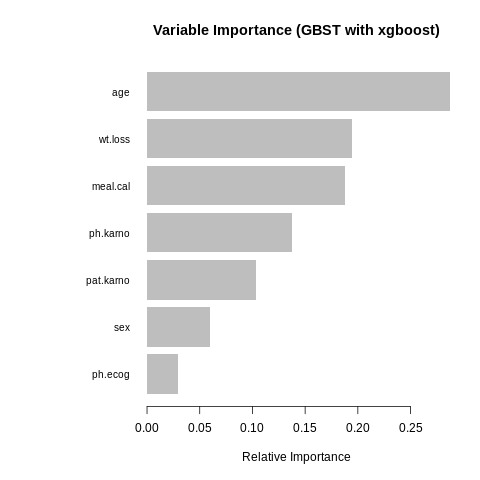

In [ ]:
%%R
# Plot variable importance
importance <- xgb.importance(model = xgb_model)
xgb.plot.importance(importance,
                    main = "Variable Importance (GBST with xgboost)",
                    xlab = "Relative Importance",
                    ylab = "")

#### Predicted and Evaluation

In [22]:
%%R
# Predict risk scores (for Cox model)
pred_risk <- predict(xgb_model, dtest)



#### Integrated Brier Score (IBS)

In [23]:
%%R
# Calculate C-index (concordance index)
cindex <- concordance(y_test ~ pred_risk)$concordance
print(paste("C-index:", round(cindex, 3)))

[1] "C-index: 0.429"


#### Integrated Brier Score (IBS)

In [24]:
%%R
# Define a prediction function for riskRegression
predictRisk.xgb.Booster <- function(object, newdata, times, ...) {
  X_new <- as.matrix(newdata[, features])
  dnew <- xgb.DMatrix(data = X_new)
  risk_scores <- predict(object, dnew)
  # Convert risk scores to survival probabilities
  surv_prob <- matrix(NA, nrow = nrow(newdata), ncol = length(times))
  for (i in 1:nrow(newdata)) {
    surv_prob[i, ] <- exp(-risk_scores[i] * times / mean(newdata$time))
  }
  return(surv_prob)
}

# Attempt to compute Brier Score and Integrated Brier Score with riskRegression
brier_model <- tryCatch(
  {
    Score(
      list("XGBoost" = xgb_model),
      formula = Surv(time, status) ~ 1,
      data = test_data,
      metrics = c("brier"),
      times = seq(0, max(test_data$time), length.out = 100),
      summary = "IBS"
    )
  },
  error = function(e) {
    message("Error in riskRegression::Score: ", e$message)
    return(NULL)
  }
)

# Extract Integrated Brier Score
ibs <- NA
if (!is.null(brier_model) && !is.null(brier_model$Brier$XGBoost)) {
  ibs <- brier_model$Brier$XGBoost$integrated[1]
} else {
  message("Falling back to manual IBS calculation due to riskRegression failure.")

  # Manual Brier Score calculation
  times <- seq(0, max(test_data$time), length.out = 100)
  surv_prob <- predictRisk.xgb.Booster(xgb_model, test_data, times)

  # Kaplan-Meier estimator for IPCW weights
  km_fit <- survfit(Surv(time, status) ~ 1, data = test_data)
  km_summary <- summary(km_fit, times = times, extend = TRUE)
  G_t <- km_summary$surv  # Survival function for censoring distribution

  # Compute Brier Score at each time point
  brier_scores <- sapply(1:length(times), function(j) {
    t <- times[j]
    surv_t <- surv_prob[, j]
    event <- test_data$status
    time <- test_data$time
    # Indicator for event or censoring before time t
    ind <- (time <= t & event == 1) | (time > t)
    # IPCW weights: 1/G(t) for events, 1/G(t) for censored after t
    weights <- ifelse(time <= t & event == 1, 1 / G_t[j], ifelse(time > t, 1 / G_t[j], 0))
    # Brier score: mean squared difference between observed and predicted
    brier <- mean(weights * ((time <= t & event == 1) - surv_t)^2, na.rm = TRUE)
    return(brier)
  })

  # Integrate Brier Scores to get IBS
  ibs <- pracma::trapz(times, brier_scores) / (max(times) - min(times))
}

# Print evaluation metrics
cat("Integrated Brier Score:", ibs, "\n")

Integrated Brier Score: 3.438889 


#### Survival Curves

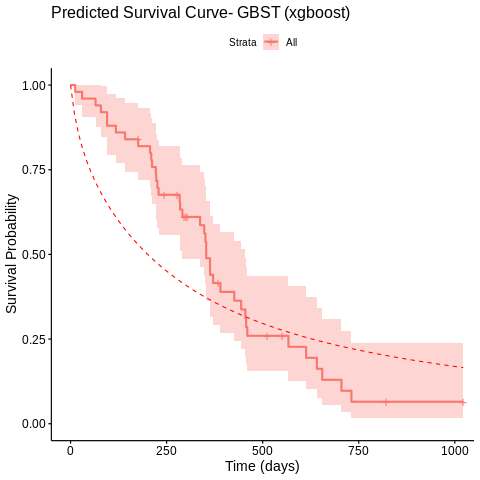

In [25]:
%%R
# Plot survival curve
times <- seq(0, max(test_data$time), length.out = 100)
surv_prob <- predictRisk.xgb.Booster(xgb_model, test_data, times)
surv_df <- data.frame(
  time = times,
  surv = colMeans(surv_prob)
)

# Create survival plot
surv_plot <- ggsurvplot(
  fit = survfit(Surv(time, status) ~ 1, data = test_data),
  data = test_data,
  title = "Predicted Survival Curve- GBST (xgboost)",
  xlab = "Time (days)",
  ylab = "Survival Probability"
)
surv_plot$plot <- surv_plot$plot +
  geom_line(data = surv_df, aes(x = time, y = surv), color = "red", linetype = "dashed")
surv_plot

## Accelerated Failure Time (AFT) Gradient Boosting (AFTBoost)

Accelerated Failure Time (AFT) Gradient Boosting is a method that models survival data by assuming that the logarithm of the survival time follows a linear model. This approach allows for flexible modeling of survival times while accounting for censoring. The AFT model can be implemented using gradient boosting techniques, which iteratively fit weak learners to improve predictions. In R, packages like {gbm} and {xgboost} can be used to implement AFT models with custom loss functions. Below is a step-by-step guide to fitting an AFT Gradient Boosting model, including data preparation, model fitting, validation, and visualization.


### Load and Prepare Data

In [26]:
%%R
#| warning: false
# Prepare lung dataset
set.seed(123)
data(lung)
# Remove missing values
lung_complete <- lung %>% na.omit()

# Split into 70% training and 30% testing
n <- nrow(lung_complete)
train_idx <- sample(1:n, size = round(0.7 * n))
train_data <- lung_complete[train_idx, ]
test_data <- lung_complete[-train_idx, ]

# Prepare data for xgboost
# Create feature matrix (exclude time and status)
features <- c("age", "sex", "ph.ecog", "ph.karno", "pat.karno", "meal.cal", "wt.loss")
X_train <- as.matrix(train_data[, features])
X_test <- as.matrix(test_data[, features])

# For AFT, survival times are log-transformed, and status is used for censoring
# xgboost expects y_lower_bound and y_upper_bound for survival data
# For uncensored: y_lower = y_upper = log(time)
# For censored: y_lower = log(time), y_upper = Inf
y_lower_train <- log(train_data$time)
y_upper_train <- ifelse(train_data$status == 2, log(train_data$time), Inf)  # status=2 is event
y_lower_test <- log(test_data$time)
y_upper_test <- ifelse(test_data$status == 2, log(test_data$time), Inf)

# Create DMatrix for xgboost with labels in constructor
dtrain <- xgb.DMatrix(data = X_train, label_lower_bound = y_lower_train, label_upper_bound = y_upper_train)
dtest <- xgb.DMatrix(data = X_test, label_lower_bound = y_lower_test, label_upper_bound = y_upper_test)

### Fit AFT Gradient Boosting Model

AFT Gradient Boosting can be implemented using the `xgboost` package in R. The model is trained to minimize the negative log-likelihood of the AFT model, which can be specified through the `objective` parameter. The provided params list is used with `objective = "survival:aft"` and `eval_metric = "aft-nloglik"`. The model is trained with xgb.train for 100 boosting rounds (`nrounds = 100`).

In [27]:
%%R
# Define parameters for AFT model
params <- list(
  objective = "survival:aft",
  eval_metric = "aft-nloglik",
  tree_method = "hist",          # efficient tree growth
  aft_loss_distribution = "normal",  # normal distribution for AFT
  aft_loss_distribution_scale = 1.0,
  max_depth = 3,
  eta = 0.1
)

# Fit AFT model using xgb.train
set.seed(123)
bst <- xgb.train(
  params = params,
  data = dtrain,
  nrounds = 100,
  verbose = 1
)
print(bst)

##### xgb.Booster
raw: 101.9 Kb 
call:
  xgb.train(params = params, data = dtrain, nrounds = 100, verbose = 1)
params (as set within xgb.train):
  objective = "survival:aft", eval_metric = "aft-nloglik", tree_method = "hist", aft_loss_distribution = "normal", aft_loss_distribution_scale = "1", max_depth = "3", eta = "0.1", validate_parameters = "TRUE"
xgb.attributes:
  niter
callbacks:
  cb.print.evaluation(period = print_every_n)
# of features: 7 
niter: 100
nfeatures : 7 


### Variable Importance

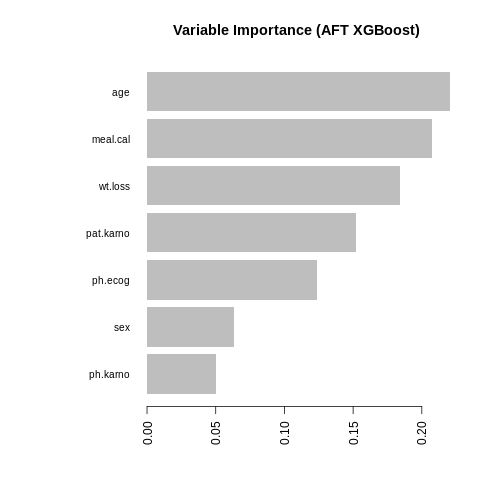

In [28]:
%%R
importance_matrix <- xgb.importance(model = bst)
xgb.plot.importance(importance_matrix, las = 2, main = "Variable Importance (AFT XGBoost)")

### Prediction and Evaluation

In [29]:
%%R
# Predict log-survival times on test set
pred_log_time <- predict(bst, dtest)
pred_time <- exp(pred_log_time)  # Exponentiate to get survival times

### Concordance index (C-Index)

In [ ]:
%%R
# Compute concordance index (C-index)
c_index <- concordance(Surv(time, status) ~ pred_time, data = test_data)$concordance
cat("C-index:", round(c_index, 3), "\n")

C-index: 0.652 


### Integrated Brier Score (IBS)

In [30]:
%%R
eval_times <- seq(0, max(test_data$time), length.out = 100)
brier_scores <- numeric(length(eval_times))

# Assume Weibull distribution for survival probabilities
aft_model <- survreg(Surv(time, status) ~ 1, data = train_data, dist = "weibull")
shape <- 1 / aft_model$scale
scale <- exp(coef(aft_model))

for (i in seq_along(eval_times)) {
  surv_probs <- exp(-(eval_times[i] / (pred_time * scale))^shape)
  brier_scores[i] <- mean((as.numeric(test_data$time > eval_times[i]) - surv_probs)^2, na.rm = TRUE)
}
ibs <- mean(brier_scores, na.rm = TRUE)
cat("Integrated Brier Score (IBS):", round(ibs, 3), "\n")

Integrated Brier Score (IBS): 0.653 


### Survival Curves

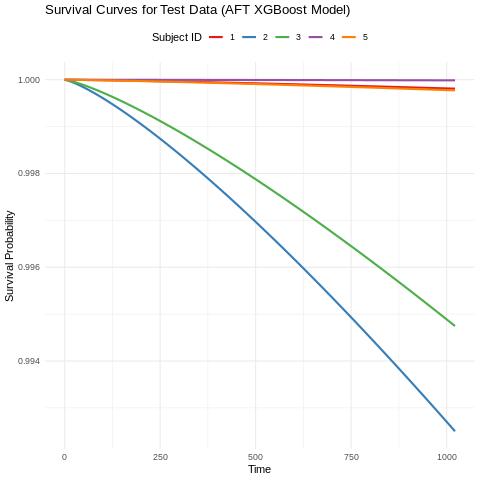

In [31]:
%%R
# Generate survival curves
# Predict survival probabilities for test data
surv_probs <- matrix(NA, nrow = nrow(test_data), ncol = length(eval_times))
for (i in 1:nrow(test_data)) {
  surv_probs[i, ] <- exp(-(eval_times / (pred_time[i] * scale))^shape)
}

# Create data frame for plotting
surv_df <- data.frame(
  Time = rep(eval_times, nrow(test_data)),
  Survival = as.vector(t(surv_probs)),
  Subject = rep(1:nrow(test_data), each = length(eval_times))
)

# Plot survival curves for a subset of subjects (first 5 for clarity)
#| fig.width: 6
#| fig.height: 4
subset_subjects <- 1:min(5, nrow(test_data))
surv_df_subset <- surv_df[surv_df$Subject %in% subset_subjects, ]

ggplot(surv_df_subset, aes(x = Time, y = Survival, color = factor(Subject))) +
  geom_line(linewidth = 1) +
  labs(title = "Survival Curves for Test Data (AFT XGBoost Model)",
       x = "Time", y = "Survival Probability",
       color = "Subject ID") +
  theme_minimal() +
  scale_color_brewer(palette = "Set1") +
  theme(legend.position = "top")

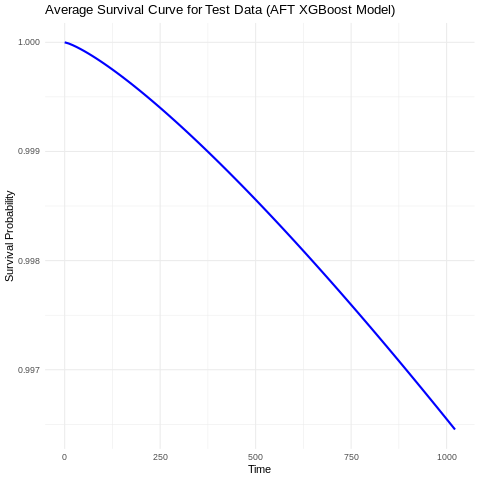

In [32]:
%%R
# Plot average survival curve
avg_surv <- colMeans(surv_probs)
avg_surv_df <- data.frame(Time = eval_times, Survival = avg_surv)

ggplot(avg_surv_df, aes(x = Time, y = Survival)) +
  geom_line(linewidth = 1, color = "blue") +
  labs(title = "Average Survival Curve for Test Data (AFT XGBoost Model)",
       x = "Time", y = "Survival Probability") +
  theme_minimal()

## Survival Gradient Boosting with Custom Loss Functions

Survival Gradient Boosting with custom loss functions allows for flexible modeling of survival data by defining specific loss functions that capture the characteristics of the survival outcome. This approach can be particularly useful when standard loss functions do not adequately represent the underlying survival process. In R, packages like {xgboost} and {gbm} can be used to implement survival gradient boosting with custom loss functions. Below is a step-by-step guide to fitting a survival gradient boosting model with a custom loss function, including data preparation, model fitting, validation, and visualization.

### Load and Prepare Data

In [ ]:
%%R
### Data and Data Preparation

# Load the lung dataset from survival package
data(lung, package = "survival")

# Remove missing values
lung_complete <- lung %>% na.omit()

# Split into 70% training and 30% testing
set.seed(123)
train_indices <- sample(1:nrow(lung_complete), size = 0.7 * nrow(lung_complete))
train_data <- lung_complete[train_indices, ]
test_data <- lung_complete[-train_indices, ]

# Training data
time_train <- train_data$time
status_train <- train_data$status - 1 # Convert to 0=censored, 1=event
X_train <- train_data %>% dplyr::select(-time, -status)
X_train_matrix <- as.matrix(X_train)

# Test data
time_test <- test_data$time
status_test <- test_data$status - 1 # Convert to 0=censored, 1=event
X_test <- test_data %>% dplyr::select(-time, -status)
X_test_matrix <- as.matrix(X_test)

# Prepare Data for XGBoost

# Create XGBoost DMatrix
dtrain <- xgb.DMatrix(X_train_matrix, label = time_train, weight = status_train)
dtest <- xgb.DMatrix(X_test_matrix, label = time_test, weight = status_test)

### Fit Survival Gradient Boosting Model with Custom Loss Function

In [35]:
%%R
### Custom Objective Function for Cox Proportional Hazards

cox_objective <- function(preds, dtrain) {
  # Custom objective function for Cox proportional hazards
  # Approximates the negative partial log-likelihood gradient and Hessian
  y_true <- getinfo(dtrain, "label") # Time-to-event or censoring time
  event_observed <- getinfo(dtrain, "weight") # Event indicator (1=event, 0=censored)

  # Sort by time in descending order for risk set
  order <- order(-y_true)
  preds_sorted <- preds[order]
  y_true_sorted <- y_true[order]
  event_observed_sorted <- event_observed[order]

  # Calculate risk set sum
  exp_preds_sorted <- exp(preds_sorted)
  risk_set_sum <- rev(cumsum(rev(exp_preds_sorted))) # Cumulative sum from the end

  # Gradient and Hessian
  gradient <- -event_observed_sorted + (event_observed_sorted * exp_preds_sorted) / risk_set_sum
  hessian <- (event_observed_sorted * exp_preds_sorted * risk_set_sum -
              (event_observed_sorted * exp_preds_sorted)^2) / risk_set_sum^2

  # Reorder back to original
  reorder <- order(order)
  list(grad = gradient[reorder], hess = hessian[reorder])
}

### Train the Model

In [ ]:
%%R

### Train the Model

# Define XGBoost parameters
params <- list(
  eta = 0.05, # Learning rate
  max_depth = 3,
  subsample = 0.8,
  colsample_bytree = 0.8,
  seed = 123,
  nthread = parallel::detectCores() - 1,
  tree_method = "hist"
)

# Number of boosting rounds
num_boost_round <- 100

# Train the model
cat(sprintf("Training XGBoost model with %d boosting rounds...\n", num_boost_round))
initial_xgb_model <- xgb.train(
  params = params,
  data = dtrain,
  nrounds = num_boost_round,
  watchlist = list(train = dtrain, eval = dtest),
  obj = cox_objective,
  verbose = 10
)

### Variable Importance

In [ ]:
%%R
# Get feature importance
importance_xgb <- xgb.importance(model = initial_xgb_model, feature_names = colnames(X_train))

# Plot variable importance
ggplot(importance_xgb, aes(x = reorder(Feature, Gain), y = Gain)) +
  geom_bar(stat = "identity") +
  coord_flip() +
  ggtitle("Feature Importance (XGBoost) - Type: 'Gain'") +
  xlab("Variable") +
  ylab("Importance (Gain)") +
  theme_minimal() +
  theme(
    panel.grid.major.x = element_line(color = "gray80"),
    panel.grid.minor.x = element_line(color = "gray90")
  )


### Prediction and Evaluation

In [39]:
%%R
# Predict log partial hazards
train_preds <- predict(initial_xgb_model, dtrain)
test_preds <- predict(initial_xgb_model, dtest)

### Concordance Index (C-index)

In [40]:
%%R
# Calculate C-index using survival package
train_cindex <- survcomp::concordance.index(
  x = train_preds,
  surv.time = time_train,
  surv.event = status_train,
  method = "noether"
)$c.index
test_cindex <- survcomp::concordance.index(
  x = test_preds,
  surv.time = time_test,
  surv.event = status_test,
  method = "noether"
)$c.index

cat(sprintf("Initial XGBoost model C-index (Train): %.3f\n", train_cindex))
cat(sprintf("Initial XGBoost model C-index (Test): %.3f\n", test_cindex))

Initial XGBoost model C-index (Train): 0.243
Initial XGBoost model C-index (Test): 0.508


### Integrated Brier Score (IBS)

In [45]:
%%R
# Define evaluation times
eval_times <- seq(0, max(time_test), length.out = 100)

# Estimate baseline cumulative hazard using Breslow estimator
train_data_baseline <- data.frame(
  time = time_train,
  status = status_train,
  hazard_ratio = exp(predict(initial_xgb_model, dtrain))
) %>% arrange(time)

unique_event_times <- unique(train_data_baseline$time[train_data_baseline$status == 1])
baseline_cumulative_hazard_values <- numeric(length(unique_event_times))
cumulative_hazard <- 0

for (i in seq_along(unique_event_times)) {
  event_time <- unique_event_times[i]
  at_risk_indices <- which(train_data_baseline$time >= event_time)
  sum_hazard_ratios <- sum(train_data_baseline$hazard_ratio[at_risk_indices])
  events_at_time <- sum(train_data_baseline$time == event_time & train_data_baseline$status == 1)
  hazard_increment <- ifelse(sum_hazard_ratios < .Machine$double.eps, 0, events_at_time / sum_hazard_ratios)
  cumulative_hazard <- cumulative_hazard + hazard_increment
  baseline_cumulative_hazard_values[i] <- cumulative_hazard
}

# Add time 0 with hazard 0
baseline_times <- c(0, unique_event_times)
baseline_values <- c(0, baseline_cumulative_hazard_values)

# Function to get baseline cumulative hazard at a given time
get_baseline_cumulative_hazard <- function(query_time, baseline_times, baseline_values) {
  if (query_time < baseline_times[1]) return(0)
  if (query_time >= baseline_times[length(baseline_times)]) return(baseline_values[length(baseline_values)])

  idx <- findInterval(query_time, baseline_times)
  if (baseline_times[idx] == query_time) return(baseline_values[idx])

  t_before <- baseline_times[idx]
  t_after <- baseline_times[idx + 1]
  lambda_before <- baseline_values[idx]
  lambda_after <- baseline_values[idx + 1]

  if (t_after - t_before == 0) return(lambda_before)
  lambda_before + (lambda_after - lambda_before) * (query_time - t_before) / (t_after - t_before)
}

# Calculate predicted survival probabilities
test_hazard_ratios <- exp(predict(initial_xgb_model, dtest))
predicted_survival_xgboost <- matrix(NA, nrow = nrow(X_test), ncol = length(eval_times))

for (i in seq_along(eval_times)) {
  lambda0_t <- get_baseline_cumulative_hazard(eval_times[i], baseline_times, baseline_values)
  predicted_survival_xgboost[, i] <- exp(-lambda0_t * test_hazard_ratios)
}

# Kaplan-Meier for censoring distribution
km_censor_fit <- survfit(Surv(time_test, 1 - status_test) ~ 1)

# Function to get censoring survival probability
get_survival_at_time <- function(query_time, km_fit) {
  idx <- findInterval(query_time, km_fit$time)
  if (idx == 0) return(1)
  if (idx >= length(km_fit$surv)) return(km_fit$surv[length(km_fit$surv)])
  km_fit$surv[idx]
}

# Calculate IBS
xgboost_brier <- numeric(length(eval_times))
for (i in seq_along(eval_times)) {
  t <- eval_times[i]
  predicted_surv <- predicted_survival_xgboost[, i]
  brier_at_t <- numeric()

  for (j in 1:length(time_test)) {
    G_min_Tt <- get_survival_at_time(min(time_test[j], t), km_censor_fit)
    G_min_Tt <- max(G_min_Tt, .Machine$double.eps) # Avoid division by zero

    if (time_test[j] <= t && status_test[j] == 1) {
      score_component <- (0 - predicted_surv[j])^2 / G_min_Tt
    } else if (time_test[j] > t) {
      score_component <- (1 - predicted_surv[j])^2 / G_min_Tt
    } else {
      score_component <- 0
    }
    brier_at_t <- c(brier_at_t, score_component)
  }

  xgboost_brier[i] <- mean(brier_at_t, na.rm = TRUE)
}



In [44]:
%%R
# Integrated Brier Score (IBS) for XGBoost model
xgboost_ibs <- mean(xgboost_brier, na.rm = TRUE)
cat(sprintf("XGBoost model IBS: %.3f\n", xgboost_ibs))

XGBoost model IBS: 0.139


### Kaplan-Meier baseline IBS

In [46]:
%%R
# Kaplan-Meier baseline IBS
km_fit <- survfit(Surv(time_test, status_test) ~ 1)
km_brier <- numeric(length(eval_times))
for (i in seq_along(eval_times)) {
  t <- eval_times[i]
  km_surv <- get_survival_at_time(t, km_fit)
  brier_at_t <- numeric()

  for (j in 1:length(time_test)) {
    G_min_Tt <- get_survival_at_time(min(time_test[j], t), km_censor_fit)
    G_min_Tt <- max(G_min_Tt, .Machine$double.eps)

    if (time_test[j] <= t && status_test[j] == 1) {
      score_component <- (0 - km_surv)^2 / G_min_Tt
    } else if (time_test[j] > t) {
      score_component <- (1 - km_surv)^2 / G_min_Tt
    } else {
      score_component <- 0
    }
    brier_at_t <- c(brier_at_t, score_component)
  }

  km_brier[i] <- mean(brier_at_t, na.rm = TRUE)
}
# Calculate Integrated Brier Score (IBS) for Kaplan-Meier baseline
km_ibs <- mean(km_brier, na.rm = TRUE)
cat(sprintf("Kaplan-Meier baseline IBS: %.3f\n", km_ibs))

Kaplan-Meier baseline IBS: 0.132


### Survival Curve

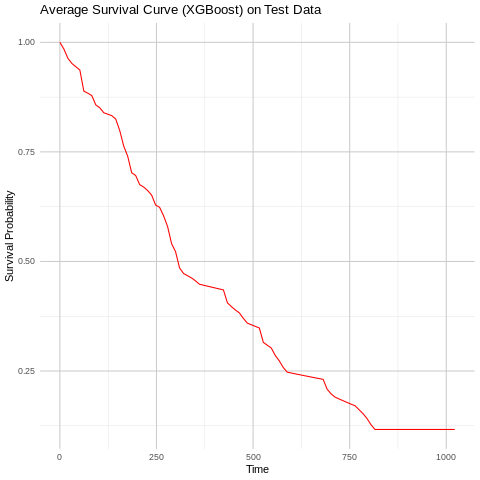

In [47]:
%%R
# Calculate average survival curve
average_surv_xgboost <- colMeans(predicted_survival_xgboost)
surv_data_xgboost <- data.frame(
  time = eval_times,
  surv = average_surv_xgboost
)

# Plot survival curve
ggplot(surv_data_xgboost, aes(x = time, y = surv)) +
  geom_line(color = "red") +
  ggtitle("Average Survival Curve (XGBoost) on Test Data") +
  xlab("Time") +
  ylab("Survival Probability") +
  theme_minimal() +
  theme(
    panel.grid.major = element_line(color = "gray80"),
    panel.grid.minor = element_line(color = "gray90")
  )

## Summary and Conclusions

This notebook explores three types of Gradient Boosted Survival Models and their implementations in R: CoxBoost, GBST, and AFTBoost.

**CoxBoost** model extends the Cox proportional hazards model using gradient boosting to model the log-hazard function. It assumes proportional hazards and optimizes the negative log-partial likelihood. The notebook demonstrates its implementation using the `{CoxBoost}` package, including data preparation, model fitting, cross-validation for penalty and steps, prediction, and evaluation using C-index and Integrated Brier Score (IBS).

**GBST (Gradient Boosting Survival Trees)** is a generic framework that applies gradient boosting to survival data using tree-based models and survival-specific loss functions. CoxBoost is a special case of GBST. The notebook shows implementations using both the `{gbm}` package (with `distribution = "coxph"`) and the `{xgboost}` package (with `objective = "survival:cox"`), covering data preparation, model fitting, cross-validation (for `{gbm}`), variable importance, prediction, and evaluation with C-index and IBS.

**AFTBoost (Accelerated Failure Time Gradient Boosting)**  models the logarithm of the survival time as a linear function of covariates, assuming predictors accelerate or decelerate the time to an event. The notebook demonstrates its implementation using the `{xgboost}` package (with `objective = "survival:aft"`), including data preparation (using `label_lower_bound` and `label_upper_bound`), model fitting, variable importance, prediction of log-survival times, and evaluation with C-index and IBS.


The notebook successfully demonstrates the implementation of three different gradient boosted survival models in R using the `{CoxBoost}`, `{gbm}`, and `{xgboost}` packages. Each model offers a distinct approach to survival analysis, with CoxBoost and GBST focusing on hazard-based modeling (often using the Cox partial likelihood) and AFTBoost directly modeling survival times. The examples provided cover essential steps like data preparation, model fitting, hyperparameter tuning (through cross-validation), assessing variable importance, and evaluating model performance using metrics like C-index and IBS. The visualizations of survival curves offer insights into the models' predictions. The notebook serves as a valuable introduction to applying gradient boosting techniques to time-to-event data in R.


## References

1. Chen, T., & Guestrin, C. (2016). XGBoost: A Scalable Tree Boosting System. *KDD '16*, 785–794.  


2. Hothorn, T., et al. (2006). Survival Ensembles. *Biostatistics, 7* (3), 355–373.  

3. Li, K., et al. (2022). Efficient Gradient Boosting for Prognostic Biomarker Discovery. *Bioinformatics, 38*(6), 1631–1638.  

4. Wang, Z., & Wang, C. Y. (2018). Gradient Boosting for Concordance Index. *Comput Math Methods Med, 2018*, 8734680.  
  

5. Zhang, H., et al. (2019). Gradient Boosting Survival Tree. *arXiv:1908.03385*.  
